In [1]:
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('classic') # 样式美化(plt.style.use)定制画布风格，这是其中一种格式
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] # 正常显示中文字体

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns

from random import random
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def PlotSARIMA(ts, model, n_steps):

    global Prediction
    global error
    global pred_ci_sarima
    global forecast
    
    data = pd.DataFrame(ts,index=ts.index) # 时间序列数据转化为dataframe数据结构，已经指定了类别，其中序列数据需要是训练集和测试集
    
    actual = series['2/2010':].Freight # 需要修改

    data['sarima_model'] = model.fittedvalues.values # 给出模型在训练集和测试集上的所有取值

    data['sarima_model'][:s+d] = np.NaN # 初始化预测值,里面涉及到模型参数季节性差分s和差分d
    
    pred = model.get_prediction(start=data.shape[0], end=data.shape[0]+n_steps, dynamic=True) # 可以直接用具体的时间进行代替
    pred_ci_sarima = pred.conf_int() # 置信区间
    Prediction = model.predict(start=data.shape[0], end=data.shape[0]+n_steps) # 预测值，也是一个Series类型
    forecast = data.sarima_model.append(Prediction)# 模型训练出来的数值和预测值

    error = mean_absolute_percentage_error(actual[s+d :], data.sarima_model[s+d :]) # 除去差分项计算模型平均绝对误差
    
    plt.figure(figsize=(18, 6))
    plt.xlabel('Year')
    #plt.ylim((0, 1)) # China
    #plt.ylim((0,0.2)) # Singapore
    plt.ylim((0,800)) # USA
    plt.ylabel('Million Ton Miles')

    #plt.title('SARIMA Model for Air Freight Transportation in the USA', fontsize=25)
    
    plt.plot(actual, linewidth = '3', color='orange', label="actual value") # color=' #054E9F'，每两个十六进制数分别代表R、G、B分量，linestyle=':'
    plt.plot(forecast['1/2012':], linewidth = '3', color='g', label="model-fitted value")
    plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")
    
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间
    plt.fill_between(pred_ci_sarima.index, pred_ci_sarima.iloc[:, 0], pred_ci_sarima.iloc[:, 1], color='dimgrey', alpha=.25)
    plt.legend(loc=2)
    plt.grid(True)
    #plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results/5.png')
    plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\USA\5.png')
    plt.show()
        
    return Prediction, error, pred_ci_sarima, forecast

# 数据导入

In [3]:
df = pd.read_excel('Journal Paper Data.xlsx',sheet_name='Air_Freight_U',header=0) 
#df.columns = ['year','Freight','SARIMA', 'Nonelinear_Air_6','l1','u1','Nonelinear_Air','l2','u2',
              #'Nonelinear_Full_Air','l3','u3','Covid']
df.columns = ['year','Freight','SARIMA', 'Nonelinear_Air_6','l1','u1','Nonelinear_Air','l2','u2',
              'Nonelinear_Full_Air','l3','u3','Nonelinear_Air_6_1','l4','u4','Covid']
df.tail(12)

,year,Freight,SARIMA,Nonelinear_Air_6,l1,u1,Nonelinear_Air,l2,u2,Nonelinear_Full_Air,l3,u3,Nonelinear_Air_6_1,l4,u4,Covid
120,2020-01-01,465.058,464.800163,465.378733,435.643429,495.114038,466.164707,433.271739,499.057674,466.164707,433.271739,499.057674,466.164707,433.271739,499.057675,0
121,2020-02-01,428.860,458.673221,459.577096,429.841915,489.312277,456.088809,423.195878,488.981741,456.088809,423.195878,488.981741,456.088809,423.195878,488.981741,0
122,2020-03-01,324.691,528.974866,324.691005,294.956842,354.425168,300.005223,267.112412,332.898035,300.005223,267.112412,332.898035,300.005223,267.112412,332.898035,1
123,2020-04-01,176.952,488.965652,176.952010,147.218006,206.686013,218.924457,186.031833,251.817081,218.924457,186.031833,251.817081,218.924457,186.031833,251.817081,1
124,2020-05-01,269.120,511.365574,269.120000,239.385997,298.854004,224.495888,191.603264,257.388512,224.495888,191.603264,257.388512,224.495888,191.603264,257.388512,1
125,2020-06-01,NaN,502.227445,214.874471,185.141334,244.607607,450.399950,417.507326,483.292574,214.629110,181.736486,247.521734,214.629110,181.736486,247.521734,1
126,2020-07-01,NaN,498.233605,240.294736,204.800677,275.788796,515.801049,479.696571,551.905528,233.725534,197.621055,269.830012,233.725534,197.621055,269.830012,1
127,2020-08-01,NaN,487.648113,210.669385,168.382222,252.956548,501.376339,457.606819,545.145859,210.206726,166.437205,253.976246,210.206726,166.437205,253.976246,1
128,2020-09-01,NaN,489.901248,429.021306,381.476350,476.566263,512.288540,464.433562,560.143519,219.332874,171.477896,267.187852,455.103714,407.248736,502.958692,1
129,2020-10-01,NaN,534.289184,573.863937,521.404473,626.323400,552.483689,499.687381,605.279997,259.177247,206.380939,311.973555,541.252763,488.456455,594.049071,1


In [4]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))
df['year'] = pd.to_datetime(df['year'], format='%m/%Y') # 数据类型转换，转化为时间序列数据，或者使用时间戳Timestamp
series = df.set_index('year') 

Time period start: 2010-01-01 00:00:00
Time period end: 2020-12-01 00:00:00


# SARIMA模型结果

D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


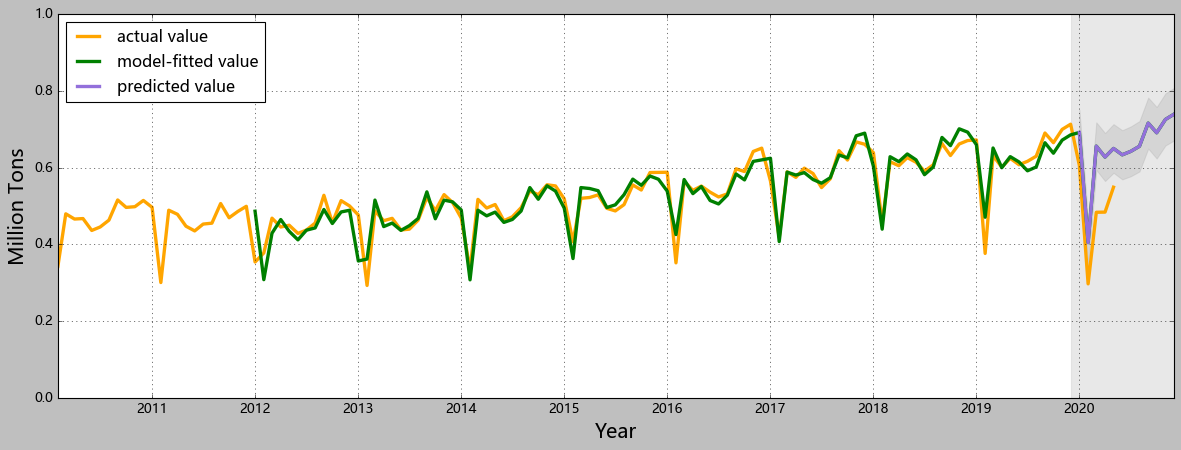

(2020-01-01    0.691493
 2020-02-01    0.404775
 2020-03-01    0.655922
 2020-04-01    0.627440
 2020-05-01    0.649883
 2020-06-01    0.633310
 2020-07-01    0.642229
 2020-08-01    0.655531
 2020-09-01    0.715950
 2020-10-01    0.690709
 2020-11-01    0.725382
 2020-12-01    0.738866
 Freq: MS, dtype: float64,
 4.342851775939971,
             lower Freight  upper Freight
 2020-01-01       0.632605       0.750382
 2020-02-01       0.345237       0.464314
 2020-03-01       0.594003       0.717840
 2020-04-01       0.565106       0.689774
 2020-05-01       0.586600       0.713167
 2020-06-01       0.569317       0.697303
 2020-07-01       0.577454       0.707005
 2020-08-01       0.590013       0.721049
 2020-09-01       0.649686       0.782213
 2020-10-01       0.623713       0.757706
 2020-11-01       0.657659       0.793105
 2020-12-01       0.670424       0.807307,
 2010-02-01         NaN
 2010-03-01         NaN
 2010-04-01         NaN
 2010-05-01         NaN
 2010-06-01         Na

In [7]:
s = 12
d = 1
catergory_data = series['2/2010':'12/2019'].Freight # China
model_pred = SARIMAX(catergory_data, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12), dynamic = True, 
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False) 
pred_ci_sarima = model_pred.get_prediction(start='1/2020', end='12/2020', dynamic=True).conf_int() # SARIMA置信区间
PlotSARIMA(catergory_data, model_pred, 11) # 该结果主要说明疫情造成了巨大的影响，影响程度可以使用外生变量模型所估计出来系数来衡量

In [8]:
outputpath= r'E:\Jupyter_Notebook\Modeling Competition_Master\Time Series_ARIMA\Journal Paper\USA\Freight_SARIMA_USA.csv' # 修改文件名
forecast.to_csv(outputpath,sep=',',index=False,header=False) # 保存SARIMA模型拟合结果

## 其他国家结果

D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


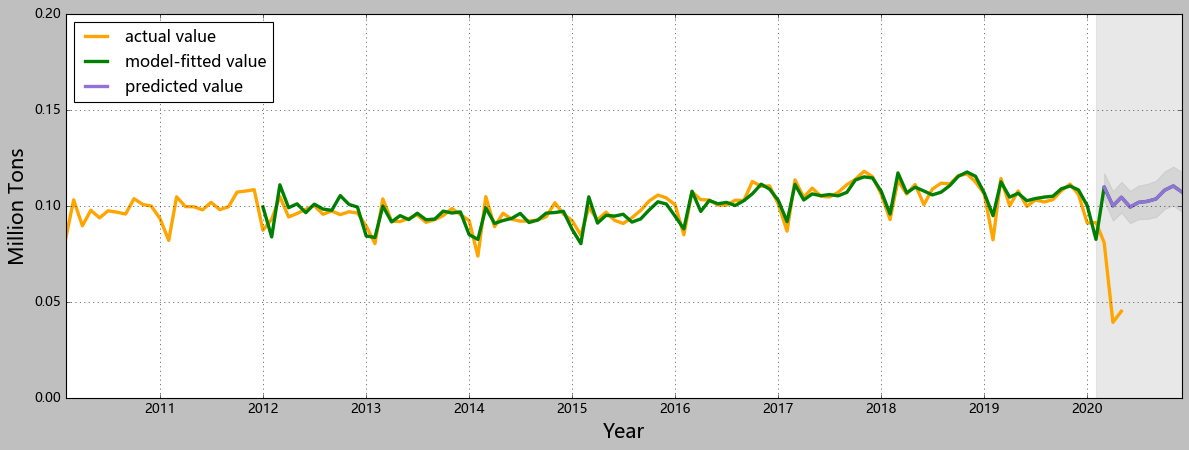

(2020-03-01    0.109879
 2020-04-01    0.100069
 2020-05-01    0.104563
 2020-06-01    0.099450
 2020-07-01    0.101887
 2020-08-01    0.102411
 2020-09-01    0.103710
 2020-10-01    0.108213
 2020-11-01    0.110427
 2020-12-01    0.107352
 Freq: MS, dtype: float64,
 3.1679341155332255,
             lower Freight  upper Freight
 2020-03-01       0.102686       0.117072
 2020-04-01       0.092454       0.107684
 2020-05-01       0.096548       0.112578
 2020-06-01       0.091054       0.107846
 2020-07-01       0.093127       0.110647
 2020-08-01       0.093301       0.111521
 2020-09-01       0.094263       0.113156
 2020-10-01       0.098441       0.117985
 2020-11-01       0.100341       0.120514
 2020-12-01       0.096961       0.117744,
 2010-02-01         NaN
 2010-03-01         NaN
 2010-04-01         NaN
 2010-05-01         NaN
 2010-06-01         NaN
                 ...   
 2020-08-01    0.102411
 2020-09-01    0.103710
 2020-10-01    0.108213
 2020-11-01    0.110427
 2020-12-

In [24]:
s = 12
d = 1
catergory_data = series['2/2010':'2/2020'].Freight # Singapore
model_pred = SARIMAX(catergory_data, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), dynamic = True, 
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False) 
pred_ci_sarima = model_pred.get_prediction(start='3/2020', end='12/2020', dynamic=True).conf_int() # SARIMA置信区间
PlotSARIMA(catergory_data, model_pred, 9) # 该结果主要说明疫情造成了巨大的影响，影响程度可以使用外生变量模型所估计出来系数来衡量

D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


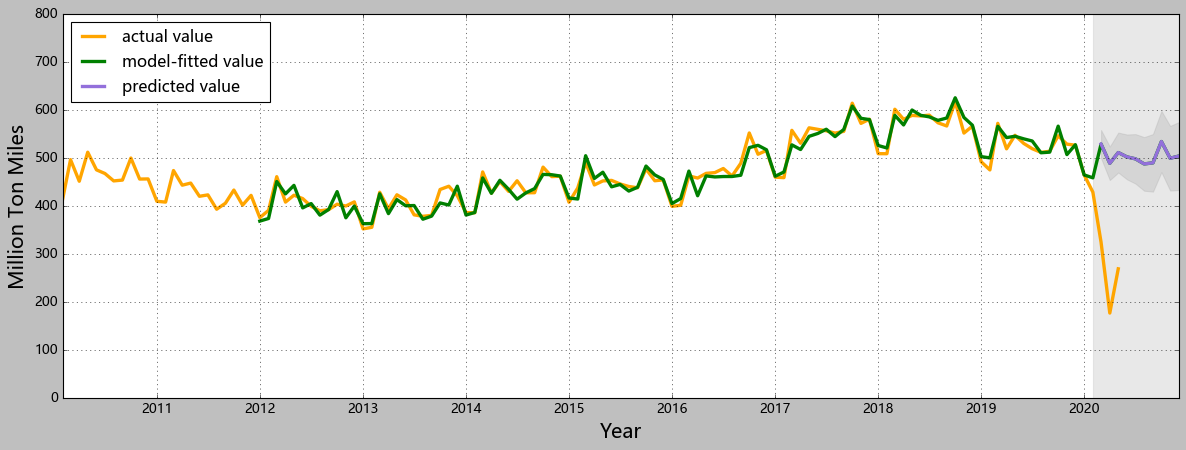

(2020-03-01    528.974866
 2020-04-01    488.965652
 2020-05-01    511.365574
 2020-06-01    502.227445
 2020-07-01    498.233605
 2020-08-01    487.648113
 2020-09-01    489.901248
 2020-10-01    534.289184
 2020-11-01    499.411062
 2020-12-01    503.960454
 Freq: MS, dtype: float64,
 2.72253472335596,
             lower Freight  upper Freight
 2020-03-01     499.717238     558.232495
 2020-04-01     454.099290     523.832013
 2020-05-01     469.823112     552.908037
 2020-06-01     455.537249     548.917641
 2020-07-01     446.721741     549.745469
 2020-08-01     431.789944     543.506282
 2020-09-01     429.991344     549.811152
 2020-10-01     470.591352     597.987015
 2020-11-01     432.136046     566.686078
 2020-12-01     433.289828     574.631080,
 2010-02-01           NaN
 2010-03-01           NaN
 2010-04-01           NaN
 2010-05-01           NaN
 2010-06-01           NaN
                  ...    
 2020-08-01    487.648113
 2020-09-01    489.901248
 2020-10-01    534.2891

In [5]:
s = 12
d = 1
catergory_data = series['2/2010':'2/2020'].Freight # USA
model_pred = SARIMAX(catergory_data, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12), dynamic = True, 
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False) 
pred_ci_sarima = model_pred.get_prediction(start='3/2020', end='12/2020', dynamic=True).conf_int() # SARIMA置信区间
PlotSARIMA(catergory_data, model_pred, 9) # 该结果主要说明疫情造成了巨大的影响，影响程度可以使用外生变量模型所估计出来系数来衡量

# 线性干预模型结构

In [9]:
endog = series.loc['2/2010':'5/2020', 'Freight'] # China
exog = series.loc['2/2010':'5/2020', 'Covid']
model_pred_exog = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12), dynamic=True, 
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
model_pred_exog.summary()

D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Freight   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                 225.867
Date:                             Sun, 02 Aug 2020   AIC                           -443.734
Time:                                     19:45:32   BIC                           -432.968
Sample:                                 02-01-2010   HQIC                          -439.368
                                      - 05-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Covid         -0.1227      0.014     -8.672      0.000      -0.150      -0.095
ar.L1         -0.3436      0.105     -3.286      0.001      -0.549      -0.139
ma.L1         -0.7911      0.072    -11.005      0.000      -0.932      -0.650
sigma2         0.0009   7.83e-05     11.817      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       49.73   Jarque-Bera (JB):               129.75
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.72
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 保存干预模型的拟合值

In [32]:
outputpath= r'E:\Jupyter_Notebook\Modeling Competition_Master\Time Series_ARIMA\Journal Paper\USA\Freight_Intervetion_USA.csv' 
exog_model_forecast.to_csv(outputpath,sep=',',index=False,header=False)

## 其他国家结果

In [25]:
endog = series.loc['2/2010':'5/2020', 'Freight'] # Singapore
exog = series.loc['2/2010':'5/2020', 'Covid']
model_pred_exog = SARIMAX(endog, exog=exog, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), dynamic=True, 
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
model_pred_exog.summary()

D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Freight   No. Observations:                  124
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 380.819
Date:                            Sun, 02 Aug 2020   AIC                           -753.639
Time:                                    20:16:51   BIC                           -743.340
Sample:                                02-01-2010   HQIC                          -749.474
                                     - 05-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Covid         -0.0478      0.001    -41.852      0.000      -0.050      -0.046
ma.L1         -0.7158      0.068    -10.538      0.000      -0.849      -0.583
ma.S.L12      -0.6641      0.109     -6.110      0.000      -0.877      -0.451
sigma2      2.217e-05   2.26e-06      9.828      0.000    1.77e-05    2.66e-05
===================================================================================
Ljung-Box (Q):                       28.44   Jarque-Bera (JB):                56.94
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
endog = series.loc['3/2010':'5/2020', 'Freight'] # USA
exog = series.loc['3/2010':'5/2020', 'Covid']
model_pred_exog = SARIMAX(endog, exog=exog, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12), dynamic=True, 
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
model_pred_exog.summary()

D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\envs\Competition_Master\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Freight   No. Observations:                  123
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -415.885
Date:                              Wed, 05 Aug 2020   AIC                            839.771
Time:                                      19:56:46   BIC                            850.070
Sample:                                  03-01-2010   HQIC                           843.935
                                       - 05-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Covid       -257.7585      5.507    -46.810      0.000    -268.551    -246.966
ar.L1         -0.6149      0.078     -7.913      0.000      -0.767      -0.463
ma.S.L12      -0.5008      0.119     -4.196      0.000      -0.735      -0.267
sigma2       307.6740     40.432      7.610      0.000     228.428     386.920
===================================================================================
Ljung-Box (Q):                       34.64   Jarque-Bera (JB):                19.38
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 线性干预模型的表现

In [7]:
def evaluate_forecast(y,pred): # 评价模型预测好坏的标准
    results = pd.DataFrame({'r2_score':r2_score(y, pred)}, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

exog_model_forecast = pd.Series(model_pred_exog.fittedvalues.values.tolist(), index=endog.index) 
exog_model_forecast[:s+d] = np.NaN 

In [8]:
evaluate_forecast(endog[s+d :], exog_model_forecast[s+d :]) # 训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.929206,14.3083,11.894211,394.688029,0.002766,3.372024,19.866757


In [9]:
evaluate_forecast(endog['3/2020' :], exog_model_forecast['3/2020' :]) # 预测数据的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.364625,39.560317,44.029734,2358.644515,0.0452,18.386424,48.565878


## 不同干预措施下的预测

In [10]:
pred_ci = model_pred_exog.get_prediction(start='6/2020', end='12/2020', exog=[[0], [0], [0], [0], [0], [0], [0]]).conf_int() # 置信区间
prediction_exog = model_pred_exog.predict(start='6/2020', end='12/2020', exog=[[0], [0], [0], [0], [0], [0], [0]])  # 设定干预措施更新到某处值
exog_forecast = exog_model_forecast.append(prediction_exog)
exog_forecast.tail(12)

2020-01-01    465.951559
2020-02-01    453.286853
2020-03-01    280.661266
2020-04-01    248.562547
2020-05-01    266.079329
2020-06-01    474.067445
2020-07-01    495.563596
2020-08-01    469.111558
2020-09-01    480.765962
2020-10-01    517.266314
2020-11-01    486.828763
2020-12-01    488.583317
dtype: float64

In [11]:
pred_ci_1 = model_pred_exog.get_prediction(start='6/2020', end='12/2020', exog=[[1], [1], [1], [1], [1], [1], [1]]).conf_int() # 置信区间
prediction_exog_1 = model_pred_exog.predict(start='6/2020', end='12/2020', exog=[[1], [1], [1], [1], [1], [1], [1]]) # 一直存在干预
exog_forecast_1 = exog_model_forecast.append(prediction_exog_1)
exog_forecast_1.tail(12)

2020-01-01    465.951559
2020-02-01    453.286853
2020-03-01    280.661266
2020-04-01    248.562547
2020-05-01    266.079329
2020-06-01    216.308993
2020-07-01    237.805145
2020-08-01    211.353107
2020-09-01    223.007511
2020-10-01    259.507863
2020-11-01    229.070312
2020-12-01    230.824866
dtype: float64

In [12]:
pred_ci_6 = model_pred_exog.get_prediction(start='6/2020', end='12/2020', exog=[[1], [1], [1], [0], [0], [0], [0]]).conf_int() # 置信区间
prediction_exog_6 = model_pred_exog.predict(start='6/2020', end='12/2020', exog=[[1], [1], [1], [0], [0], [0], [0]]) # 设定干预措施6个月
exog_forecast_6 = exog_model_forecast.append(prediction_exog_6)
exog_forecast_6.tail(12)

2020-01-01    465.951559
2020-02-01    453.286853
2020-03-01    280.661266
2020-04-01    248.562547
2020-05-01    266.079329
2020-06-01    216.308993
2020-07-01    237.805145
2020-08-01    211.353107
2020-09-01    480.765962
2020-10-01    517.266314
2020-11-01    486.828763
2020-12-01    488.583317
dtype: float64

# 线性干预模型结果

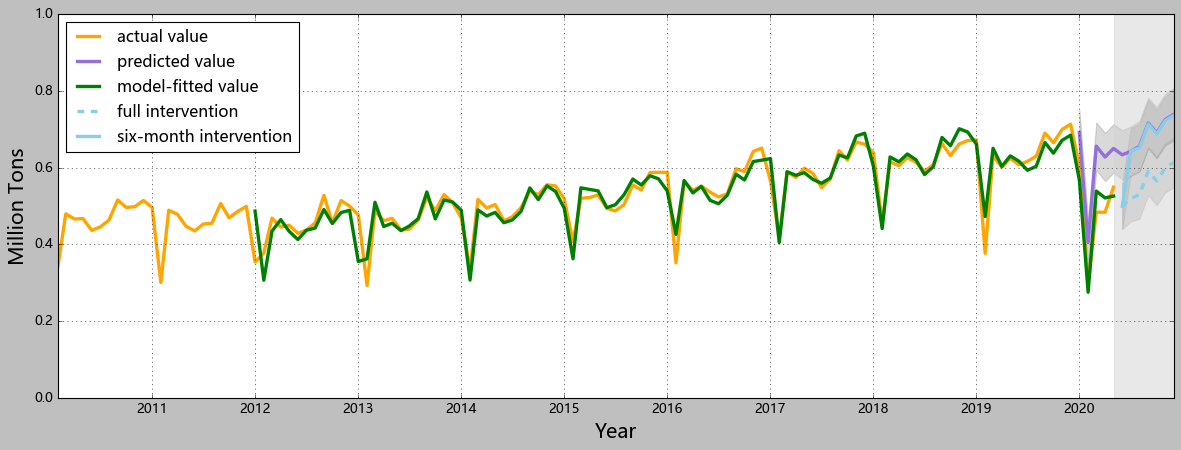

In [17]:
exog_model_forecast = pd.Series(model_pred_exog.fittedvalues.values.tolist(), index=endog.index) 
exog_model_forecast[:s+d] = np.NaN

plt.figure(figsize=(18, 6))
plt.xlabel('Year') 
plt.ylim((0, 1))
plt.ylabel('Million Tons') 
#plt.title('Linear Intervention Model for Air Freight Transportation in China',fontsize=25) 

plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(exog_model_forecast['1/2012':], linewidth = '3', color='g',label="model-fitted value")
plt.plot(prediction_exog_1, linewidth = '3', color='skyblue',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(prediction_exog, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(prediction_exog_6, linewidth = '3', color='skyblue', linestyle='-', label="six-month intervention")

plt.axvspan(endog.index[-1], exog_forecast_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(pred_ci_sarima.index, pred_ci_sarima.iloc[:, 0], pred_ci_sarima.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_1.index, pred_ci_1.iloc[:, 0], pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_6.index, pred_ci_6.iloc[:, 0], pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)

plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results/6.png')
plt.show()

## 其他国家结果

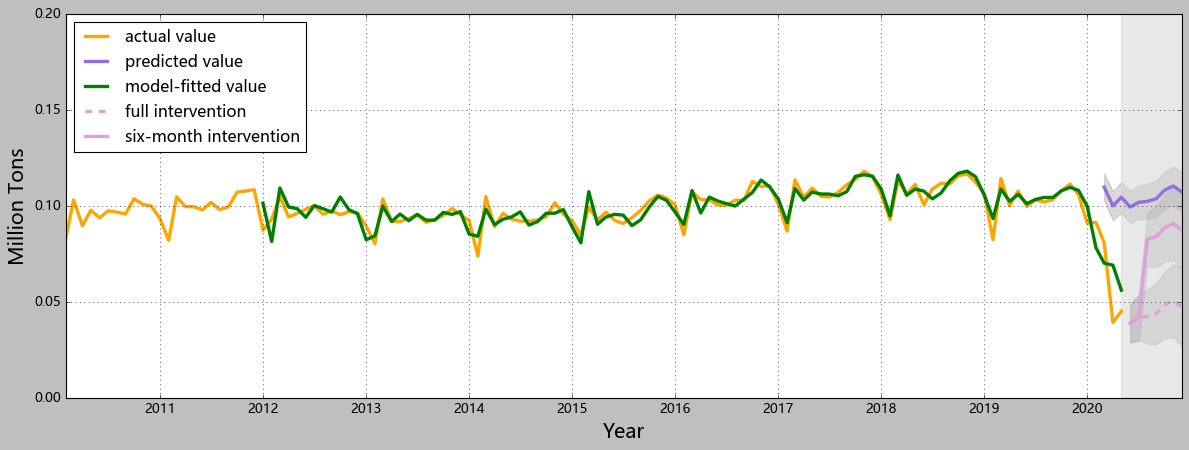

In [34]:
exog_model_forecast = pd.Series(model_pred_exog.fittedvalues.values.tolist(), index=endog.index) 
exog_model_forecast[:s+d] = np.NaN

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0, 0.2))
plt.ylabel('Million Tons')

#plt.title('Linear Intervention Model for Air Freight Transportation in Singapore',fontsize=25) 

plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(exog_model_forecast['1/2012':], linewidth = '3', color='g',label="model-fitted value")
plt.plot(prediction_exog_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(prediction_exog, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(prediction_exog_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.axvspan(endog.index[-1], exog_forecast_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(pred_ci_sarima.index, pred_ci_sarima.iloc[:, 0], pred_ci_sarima.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_1.index, pred_ci_1.iloc[:, 0], pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_6.index, pred_ci_6.iloc[:, 0], pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)

plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\Singapore\5.png')
plt.show()

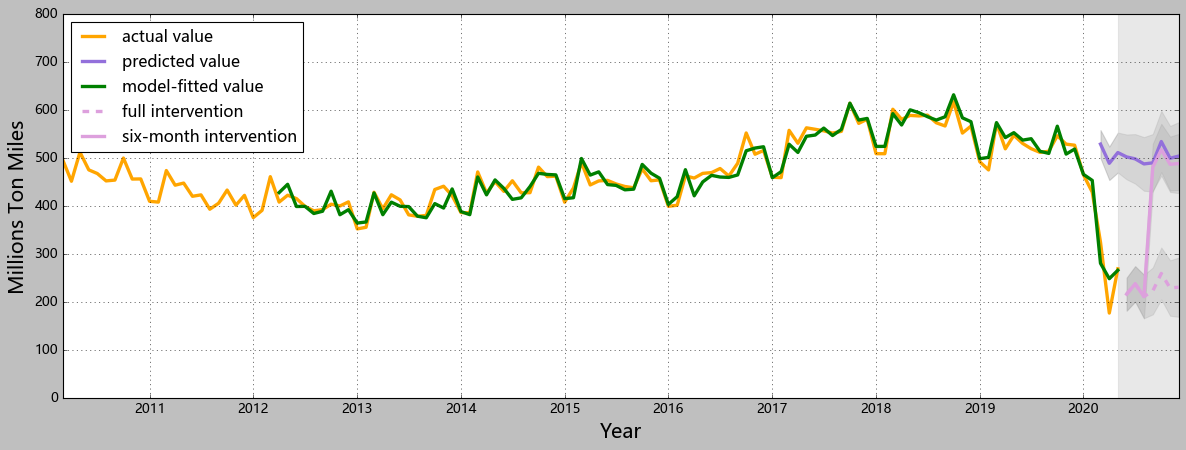

In [13]:
exog_model_forecast = pd.Series(model_pred_exog.fittedvalues.values.tolist(), index=endog.index) 
exog_model_forecast[:s+d+12] = np.NaN

error_intervention = mean_absolute_percentage_error(endog[s+d:], exog_model_forecast[s+d:])

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0,800))
plt.ylabel('Millions Ton Miles')

#plt.title('Linear Intervention Model for Air Freight Transportation in the USA',fontsize=25) 

plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(exog_model_forecast['1/2012':], linewidth = '3', color='g',label="model-fitted value")
plt.plot(prediction_exog_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(prediction_exog, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(prediction_exog_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.axvspan(endog.index[-1], exog_forecast_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(pred_ci_sarima.index, pred_ci_sarima.iloc[:, 0], pred_ci_sarima.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_1.index, pred_ci_1.iloc[:, 0], pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_6.index, pred_ci_6.iloc[:, 0], pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)

plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\USA\6.png')
plt.show()

# 非线性干预模型结果展示

## 比较不同国家的管控措施都维持在6个月，模型结构是两参数

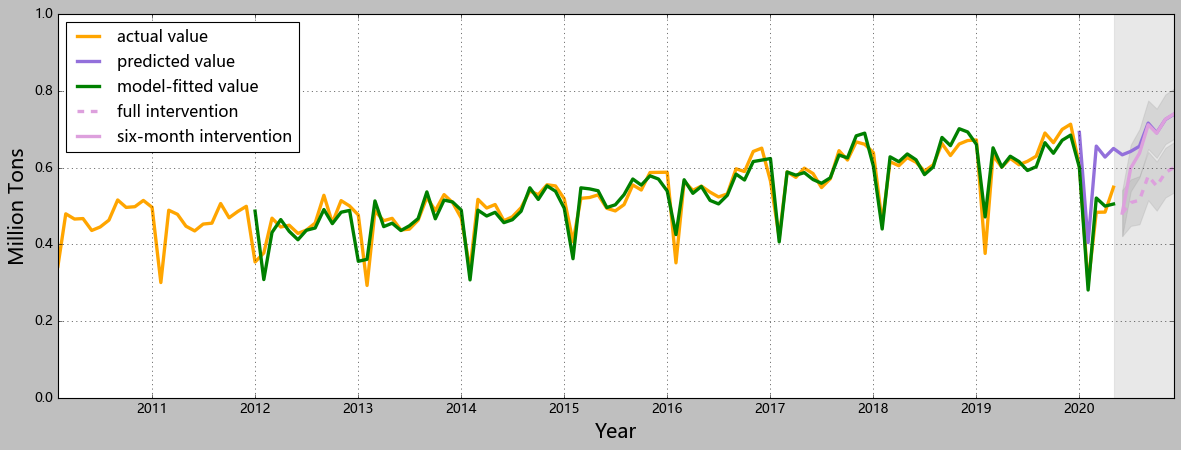

In [18]:
sas_forecast = series['1/2012':'5/2020'].Nonelinear_Full_Air # 非线性拟合值，模型一（2个参数的情况）
#sas_pred = series['5/2020':].Nonelinear_Air # 干预措施存在时间段
sas_pred_6 = series['6/2020':].Nonelinear_Air_6 # 干预措施维持6个月
sas_pred_1 = series['6/2020':].Nonelinear_Full_Air # 干预措施一直存在，5月开始目的在于两段数据能够接上

#sas_pred_ci = series.loc['6/2020':'12/2020', ['l2','u2']]
sas_pred_ci_6 = series.loc['6/2020':'12/2020', ['l1','u1']] 
sas_pred_ci_1 = series.loc['6/2020':'12/2020', ['l3','u3']]

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0,1))
plt.ylabel('Million Tons')

#plt.title('Nonlinear Intervention Model for Air Freight Transportation in China', fontsize=25) 
plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(sas_forecast, linewidth = '3', color='g',label="model-fitted value")
plt.plot(sas_pred_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(sas_pred, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(sas_pred_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.annotate('January', xy=(datetime(2020,1,1), 0.61), xytext=(datetime(2019,2,1), 0.4), arrowprops=dict(arrowstyle='->'))
plt.annotate('February', xy=(datetime(2020,2,1), 0.3), xytext=(datetime(2019,4,1), 0.25), arrowprops=dict(arrowstyle='->'))
plt.annotate('June', xy=(datetime(2020,6,1), 0.48), xytext=(datetime(2020,6,1), 0.35), arrowprops=dict(arrowstyle='->'))

plt.axvspan(sas_forecast.index[-1], sas_pred_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(sas_pred_ci_1.index, sas_pred_ci_1.iloc[:, 0], sas_pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(sas_pred_ci.index, sas_pred_ci.iloc[:, 0], sas_pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_6.index, sas_pred_ci_6.iloc[:, 0], sas_pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)
plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results/7.png')
plt.show()

In [19]:
evaluate_forecast(series['1/2012':'5/2020'].Nonelinear_Air_6, series.loc['1/2012':'5/2020', 'Freight']) # 两参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.8818,0.02154,0.015835,0.000957,0.000451,4.415761,0.030936


In [20]:
evaluate_forecast(series['1/2020':'5/2020'].Nonelinear_Air_6, series.loc['1/2020':'5/2020', 'Freight']) # 两参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.932658,0.023529,0.01609,0.000765,0.000342,5.096555,0.02765


## 其他国家结果

## 比较不同国家的管控措施都维持在6个月，模型结构是三参数

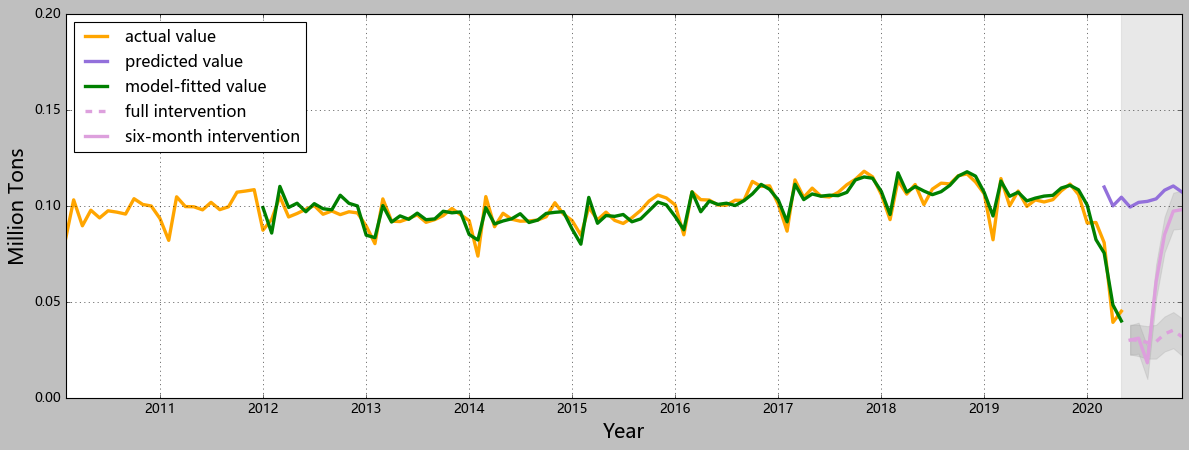

In [42]:
sas_forecast = series['1/2012':'5/2020'].Nonelinear_Full_Air # 非线性拟合值，模型一（2个参数的情况）
#sas_pred = series['5/2020':].Nonelinear_Air # 干预措施存在时间段
sas_pred_6 = series['6/2020':].Nonelinear_Air_6 # 干预措施维持6个月
sas_pred_1 = series['6/2020':].Nonelinear_Full_Air # 干预措施一直存在，5月开始目的在于两段数据能够接上

#sas_pred_ci = series.loc['6/2020':'12/2020', ['l2','u2']]
sas_pred_ci_6 = series.loc['6/2020':'12/2020', ['l1','u1']] 
sas_pred_ci_1 = series.loc['6/2020':'12/2020', ['l3','u3']]

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0, 0.2))
plt.ylabel('Million Tons')

#plt.title('Nonlinear Intervention Model for Air Freight Transportation in China', fontsize=25) 
plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(sas_forecast, linewidth = '3', color='g',label="model-fitted value")
plt.plot(sas_pred_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(sas_pred, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(sas_pred_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.annotate('February', xy=(datetime(2020,2,1), 0.09), xytext=(datetime(2019,4,1), 0.07), arrowprops=dict(arrowstyle='->'))
plt.annotate('April', xy=(datetime(2020,4,1), 0.04), xytext=(datetime(2019,6,1), 0.05), arrowprops=dict(arrowstyle='->'))
plt.annotate('July', xy=(datetime(2020,7,1), 0.03), xytext=(datetime(2020,7,1), 0.06), arrowprops=dict(arrowstyle='->'))
plt.annotate('August', xy=(datetime(2020,8,1), 0.02), xytext=(datetime(2020,4,1), 0.01), arrowprops=dict(arrowstyle='->'))

plt.axvspan(sas_forecast.index[-1], sas_pred_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(sas_pred_ci_1.index, sas_pred_ci_1.iloc[:, 0], sas_pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(sas_pred_ci.index, sas_pred_ci.iloc[:, 0], sas_pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_6.index, sas_pred_ci_6.iloc[:, 0], sas_pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)
plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\Singapore\6.png')
plt.show()

In [43]:
evaluate_forecast(series['1/2012':'5/2020'].Nonelinear_Air_6, series.loc['1/2012':'5/2020', 'Freight']) # 三参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.884955,0.003033,0.002489,0.000016,0.000013,3.259126,0.003979


In [44]:
evaluate_forecast(series['2/2012':'5/2020'].Nonelinear_Air_6, series.loc['2/2012':'5/2020', 'Freight']) # 三参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.895273,0.002943,0.002456,0.000015,0.000012,3.171199,0.003815


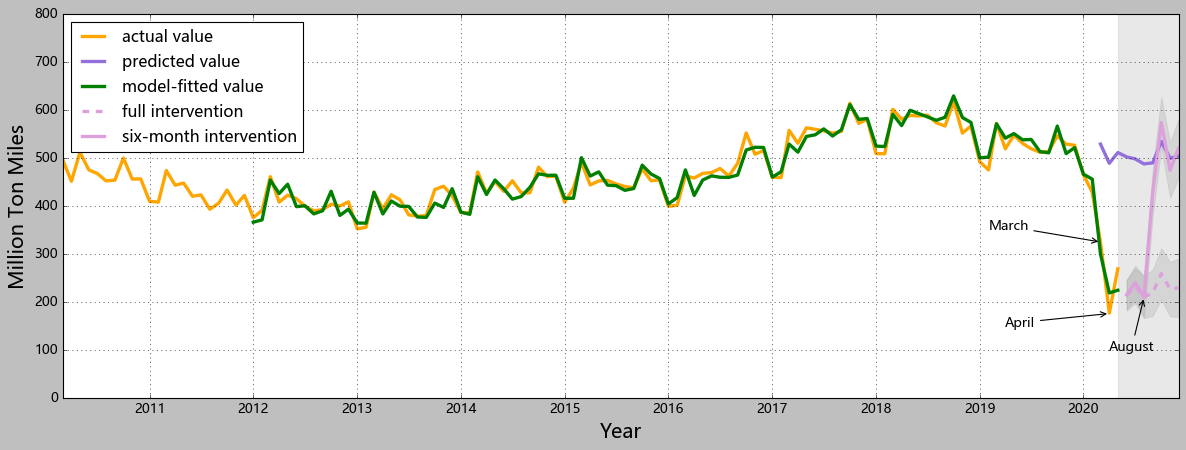

In [17]:
sas_forecast = series['1/2012':'5/2020'].Nonelinear_Full_Air # 非线性拟合值，模型一（2个参数的情况）
#sas_pred = series['5/2020':].Nonelinear_Air # 干预措施存在时间段
sas_pred_6 = series['6/2020':].Nonelinear_Air_6 # 干预措施维持6个月
sas_pred_1 = series['6/2020':].Nonelinear_Full_Air # 干预措施一直存在，5月开始目的在于两段数据能够接上

#sas_pred_ci = series.loc['6/2020':'12/2020', ['l2','u2']]
sas_pred_ci_6 = series.loc['6/2020':'12/2020', ['l1','u1']] 
sas_pred_ci_1 = series.loc['6/2020':'12/2020', ['l3','u3']]

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0,800))
plt.ylabel('Million Ton Miles')

#plt.title('Nonlinear Intervention Model for Air Freight Transportation in the USA', fontsize=25) 

plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(sas_forecast, linewidth = '3', color='g',label="model-fitted value")
plt.plot(sas_pred_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(sas_pred, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(sas_pred_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.annotate('March', xy=(datetime(2020,3,1), 325), xytext=(datetime(2019,2,1), 350), arrowprops=dict(arrowstyle='->'))
plt.annotate('April', xy=(datetime(2020,4,1), 176), xytext=(datetime(2019,4,1), 150), arrowprops=dict(arrowstyle='->'))
plt.annotate('August', xy=(datetime(2020,8,1), 210), xytext=(datetime(2020,4,1), 100), arrowprops=dict(arrowstyle='->'))

plt.axvspan(sas_forecast.index[-1], sas_pred_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(sas_pred_ci_1.index, sas_pred_ci_1.iloc[:, 0], sas_pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(sas_pred_ci.index, sas_pred_ci.iloc[:, 0], sas_pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_6.index, sas_pred_ci_6.iloc[:, 0], sas_pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)
plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\USA\7.png')
plt.show()

In [63]:
evaluate_forecast(series['1/2012':'5/2020'].Nonelinear_Air_6, series.loc['1/2012':'5/2020', 'Freight']) # 三参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.964136,11.159326,9.421899,217.287759,0.001028,2.414589,14.740684


In [64]:
evaluate_forecast(series['3/2012':'5/2020'].Nonelinear_Air_6, series.loc['3/2012':'5/2020', 'Freight']) # 三参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.963649,11.126372,9.421899,217.527585,0.00102,2.393742,14.748816


## 比较不同国家的管控措施都维持在6个月，模型结构是两参数

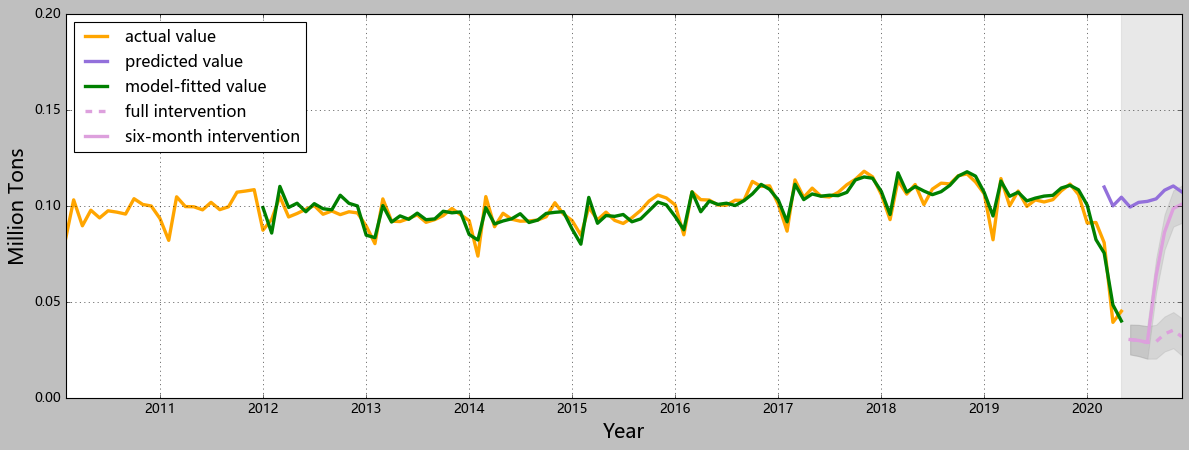

In [39]:
sas_forecast = series['1/2012':'5/2020'].Nonelinear_Full_Air # 非线性拟合值，模型一（2个参数的情况）
#sas_pred = series['5/2020':].Nonelinear_Air # 干预措施存在时间段
sas_pred_6 = series['6/2020':].Nonelinear_Air_6_1 # 干预措施维持6个月
sas_pred_1 = series['6/2020':].Nonelinear_Full_Air # 干预措施一直存在，5月开始目的在于两段数据能够接上

#sas_pred_ci = series.loc['6/2020':'12/2020', ['l2','u2']]
sas_pred_ci_6_1 = series.loc['6/2020':'12/2020', ['l4','u4']] 
sas_pred_ci_1 = series.loc['6/2020':'12/2020', ['l3','u3']]

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0,0.2))
plt.ylabel('Million Tons')

#plt.title('Nonlinear Intervention Model for Air Freight Transportation in Singapore', fontsize=25) 

plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(sas_forecast, linewidth = '3', color='g',label="model-fitted value")
plt.plot(sas_pred_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(sas_pred, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(sas_pred_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.axvspan(sas_forecast.index[-1], sas_pred_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(sas_pred_ci_1.index, sas_pred_ci_1.iloc[:, 0], sas_pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(sas_pred_ci.index, sas_pred_ci.iloc[:, 0], sas_pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_6_1.index, sas_pred_ci_6_1.iloc[:, 0], sas_pred_ci_6_1.iloc[:, 1], color='dimgrey', alpha=.25)
plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\Singapore\7.png')
plt.show()

In [40]:
evaluate_forecast(series['1/2012':'5/2020'].Nonelinear_Air_6_1, series.loc['1/2012':'5/2020', 'Freight']) # 两参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.874124,0.003172,0.002616,0.000017,0.000014,3.431219,0.004139


In [41]:
evaluate_forecast(series['2/2020':'5/2020'].Nonelinear_Air_6_1, series.loc['2/2020':'5/2020', 'Freight']) # 两参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.827925,0.007121,0.007159,0.000054,0.000048,12.339711,0.007369


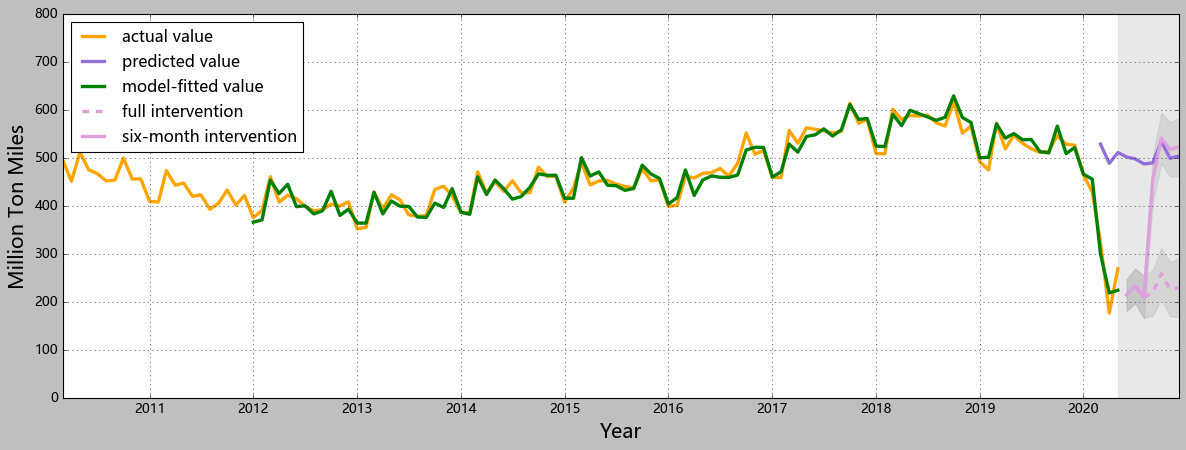

In [65]:
sas_forecast = series['1/2012':'5/2020'].Nonelinear_Full_Air # 非线性拟合值，模型一（2个参数的情况）
#sas_pred = series['5/2020':].Nonelinear_Air # 干预措施存在时间段
sas_pred_6 = series['6/2020':].Nonelinear_Air_6_1 # 干预措施维持6个月
sas_pred_1 = series['6/2020':].Nonelinear_Full_Air # 干预措施一直存在，5月开始目的在于两段数据能够接上

#sas_pred_ci = series.loc['6/2020':'12/2020', ['l2','u2']]
sas_pred_ci_6_1 = series.loc['6/2020':'12/2020', ['l4','u4']] 
sas_pred_ci_1 = series.loc['6/2020':'12/2020', ['l3','u3']]

plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0,800))
plt.ylabel('Million Ton Miles')

#plt.title('Nonlinear Intervention Model for Air Freight Transportation in the USA', fontsize=25) 

plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")

plt.plot(sas_forecast, linewidth = '3', color='g',label="model-fitted value")
plt.plot(sas_pred_1, linewidth = '3', color='plum',linestyle='--', label="full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(sas_pred, linewidth = '3', color='plum', linestyle='--', label="linear_intervention")
plt.plot(sas_pred_6, linewidth = '3', color='plum', linestyle='-', label="six-month intervention")

plt.axvspan(sas_forecast.index[-1], sas_pred_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(sas_pred_ci_1.index, sas_pred_ci_1.iloc[:, 0], sas_pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
#plt.fill_between(sas_pred_ci.index, sas_pred_ci.iloc[:, 0], sas_pred_ci.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_6_1.index, sas_pred_ci_6_1.iloc[:, 0], sas_pred_ci_6_1.iloc[:, 1], color='dimgrey', alpha=.25)
plt.legend(loc=2)
plt.grid(True)
plt.savefig(r'E:\SUSTech\Research_Papers\Journal_Paper_2020\创新项目\Appendix\results\USA\8.png')
plt.show()

In [66]:
evaluate_forecast(series['1/2012':'5/2020'].Nonelinear_Air_6_1, series.loc['1/2012':'5/2020', 'Freight']) # 两参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.956262,12.811005,10.719439,270.402278,0.001901,3.000762,16.443913


In [67]:
evaluate_forecast(series['3/2020':'5/2020'].Nonelinear_Air_6_1, series.loc['3/2020':'5/2020', 'Freight']) # 两参数训练集上的表现

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.063409,37.094115,41.972457,1454.128705,0.027888,15.759347,38.13304


## 比较不同国家的管控措施，两种干预模型的结果，只需要讨论中国

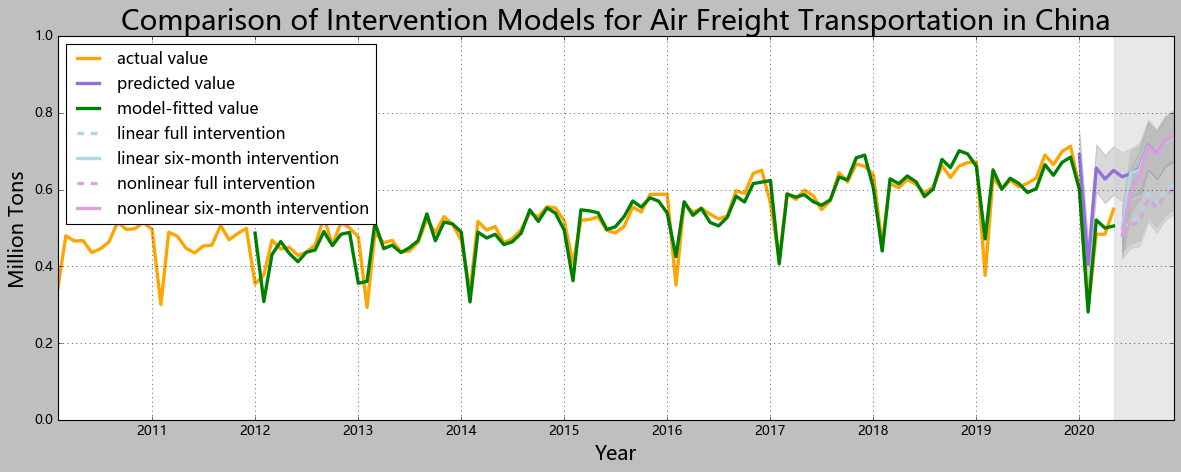

In [26]:
plt.figure(figsize=(18, 6))
plt.xlabel('Year')
plt.ylim((0,1))
plt.ylabel('Million Tons')

plt.title('Comparison of Intervention Models for Air Freight Transportation in China', fontsize=25) 
plt.plot(endog, linewidth = '3', color='orange', label="actual value")
plt.plot(Prediction, linewidth = '3', color='mediumpurple', label="predicted value")
plt.plot(sas_forecast, linewidth = '3', color='g',label="model-fitted value")

#plt.plot(prediction_exog, linewidth = '3', color='thistle',linestyle='--', label="intervention") 
plt.plot(prediction_exog_1, linewidth = '3', color='lightblue',linestyle='--', label="linear full intervention") 
plt.plot(prediction_exog_6, linewidth = '3', color='lightblue', linestyle='-', label="linear six-month intervention")

plt.plot(sas_pred_1, linewidth = '3', color='plum',linestyle='--', label="nonlinear full intervention") # 此时需要选取一个最佳的线性结构
#plt.plot(sas_pred, linewidth = '3', color='plum', linestyle='--', label="intervention")
plt.plot(sas_pred_6, linewidth = '3', color='plum', linestyle='-', label="nonlinear six-month intervention")

plt.axvspan(endog.index[-1], exog_forecast_1.index[-1], alpha=0.5, color='lightgrey') # 标注出来预测区间

plt.fill_between(pred_ci_sarima.index, pred_ci_sarima.iloc[:, 0], pred_ci_sarima.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_1.index, pred_ci_1.iloc[:, 0], pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(pred_ci_6.index, pred_ci_6.iloc[:, 0], pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_1.index, sas_pred_ci_1.iloc[:, 0], sas_pred_ci_1.iloc[:, 1], color='dimgrey', alpha=.25)
plt.fill_between(sas_pred_ci_6.index, sas_pred_ci_6.iloc[:, 0], sas_pred_ci_6.iloc[:, 1], color='dimgrey', alpha=.25)
plt.legend(loc=2)
plt.grid(True)
plt.savefig('Journal Paper/China/Freight_5.png')
plt.show()